# BD04 Data Science - Casus Anomaly Detection

#### Projectleden:
Chantal Favié, Kane Doornbos, Max Smeets, Sabrine Bouchmal

### Opdrachtgevers/begeleiders
Jan Baljan, Maarten Vaessen, Roel Bindels 


## Inleiding
Aanleiding/doelstelling

## Data retrieval

In [14]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [35]:
pd.set_option('display.max_columns',100)

In [36]:
# Read json file
files = [
            './data/Testpersoon-D/D-Zit1.json', 
            './data/Testpersoon-D/D-Zit2.json', 
            './data/Testpersoon-D/D-Zit3.json',
            './data/Testpersoon-D/D-Zit4.json',
            './data/Testpersoon-D/D-Zit5.json'
        ]

df = pd.DataFrame([])

for file in range(len(files)):
    with open(files[file]) as data_file:
        data = json.load(data_file)
        df = pd.concat([df, pd.json_normalize(data['hits']['hits'])])

df


{'took': 9, 'timed_out': False, '_shards': {'total': 2, 'successful': 2, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 391, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'logstash-2021.03.10-000001', '_type': '_doc', '_id': 'OQ1QHHgBhLy4-w68VDSV', '_score': 1.0, '_source': {'frameDate': '2021-03-10T13:25:29.142Z', 'y': 333.63315456108364, 'x': 285.7587406143604, 'keypointName': 'rightKnee', 'keypointScore': 0.9944058656692505, '@version': '1', 'frameScore': 0.9411248249166152, 'testStart': '2021-03-10T13:25:25.288Z', 'elapsedSeconds': 3963, '@timestamp': '2021-03-10T13:25:29.630Z'}}, {'_index': 'logstash-2021.03.10-000001', '_type': '_doc', '_id': 'Og1QHHgBhLy4-w68VDSV', '_score': 1.0, '_source': {'frameDate': '2021-03-10T13:25:29.142Z', 'y': 247.03953326444218, 'x': 263.0282795382845, 'keypointName': 'rightWrist', 'keypointScore': 0.9984033703804016, '@version': '1', 'frameScore': 0.9411248249166152, 'testStart': '2021-03-10T13:25:25.288Z', 'elapsedSeconds': 3963,

,_index,_type,_id,_score,_source.frameDate,_source.y,_source.x,_source.keypointName,_source.keypointScore,_source.@version,_source.frameScore,_source.testStart,_source.elapsedSeconds,_source.@timestamp
0,logstash-2021.03.10-000001,_doc,OQ1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,333.633155,285.758741,rightKnee,0.994406,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.630Z
1,logstash-2021.03.10-000001,_doc,Og1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,247.039533,263.028280,rightWrist,0.998403,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.632Z
2,logstash-2021.03.10-000001,_doc,Ow1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,127.600087,284.910068,rightShoulder,0.998896,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.634Z
3,logstash-2021.03.10-000001,_doc,PA1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.142Z,72.860357,309.362101,rightEye,0.990845,1,0.941125,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.635Z
4,logstash-2021.03.10-000001,_doc,PQ1QHHgBhLy4-w68VDSV,1.0,2021-03-10T13:25:29.012Z,422.327084,358.200198,leftAnkle,0.727294,1,0.939658,2021-03-10T13:25:25.288Z,3963,2021-03-10T13:25:29.637Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,logstash-2021.03.10-000001,_doc,1w1THHgBhLy4-w68Gz4N,1.0,2021-03-10T13:28:27.547Z,205.629069,257.848701,rightElbow,0.968070,1,0.885256,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.697Z
659,logstash-2021.03.10-000001,_doc,uQ1THHgBhLy4-w68Gz4A,1.0,2021-03-10T13:28:28.475Z,163.412351,328.019236,leftEar,0.595790,1,0.875168,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.681Z
660,logstash-2021.03.10-000001,_doc,3A1THHgBhLy4-w68Gz4N,1.0,2021-03-10T13:28:27.547Z,160.321940,333.302835,leftEar,0.595728,1,0.885256,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.697Z
661,logstash-2021.03.10-000001,_doc,wA1THHgBhLy4-w68Gz4A,1.0,2021-03-10T13:28:28.240Z,200.846319,444.508343,leftWrist,0.840393,1,0.890357,2021-03-10T13:28:26.493Z,4738,2021-03-10T13:28:31.684Z


In [9]:
#Score fetcher
def fetchScore(df, i):
    if i >= len(df):
        plt.xlabel('Keypoint score')
        plt.ylabel('Frame score')
        plt.show()
    else:
        plt.scatter(df['_source.keypointScore'][i],df['_source.frameScore'][i])
        fetchScore(df, i+1)
 

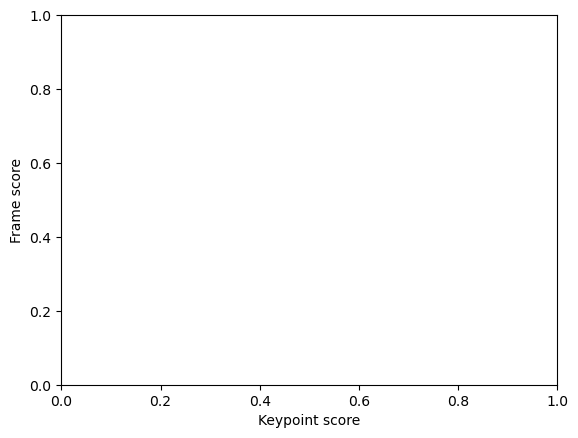

In [16]:
fetchScore(df,0)

## Data cleaning

## Data visualisation

## Model

- PoseNet
- Mediapipe
- MoveNet Lightning
- MoveNet Thunder

## Aantekeningen meeting week 2
- POSENET tensorflow library voor oefeningen gebruikt
- Ook andere modellen mogelijk (mediapipe)
- Model zsm draaiende hebben, dan zelf video opnamens maken
- Kibana (dashboard voor data te bekijken)